In [1]:
%config Completer.use_jedi = False

### Sequential 모델

In [2]:
# class로 만들기
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [3]:
# 점진적으로 시퀀셜 모델 만들기
model = keras.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
# build()메서드 호출전 모델의 가중치 확인
model.weights # build전은 에러남

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [5]:
# build 후
model.build(input_shape=(None, 3)) # 샘플이 (3,)인 것을 기대, 입력 크기 None은 어떤 크기도 가능하다라는뜻
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[ 0.09361467, -0.25918558, -0.22751275,  0.08542386,  0.16781494,
          0.27976823, -0.15165952,  0.0136452 ,  0.09650546, -0.13126956,
         -0.07093112, -0.25900885, -0.26856408, -0.01649252, -0.08122219,
          0.25958043,  0.22354794,  0.0689837 ,  0.15959594,  0.20945537,
         -0.15592003,  0.16671962, -0.00437644, -0.07794008, -0.1166106 ,
          0.14630526,  0.1714032 ,  0.11523467, -0.0920852 , -0.00419679,
         -0.04665315,  0.17530707,  0.05127034, -0.08746204,  0.22327238,
         -0.28860092, -0.12998895, -0.06558463, -0.11163183, -0.23791791,
          0.23433751,  0.04534692,  0.05175272, -0.1966241 , -0.08791958,
          0.2712412 ,  0.09556061,  0.20406967, -0.11678411,  0.21307576,
          0.11928284,  0.13738841,  0.06402525,  0.16523722,  0.2026813 ,
         -0.23297518,  0.09171328,  0.1222128 ,  0.0545103 , -0.05045597,
          0.11925688, -0.06630602,  0.19428

In [6]:
# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [7]:
# name 변수를 활용하면 이름을 지정할 수 있음
model = keras.Sequential(name='my_example_model')
model.add(layers.Dense(64, activation='relu', name='my_first_layer'))
model.add(layers.Dense(10, activation='softmax', name='my_last_layer'))
model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 모델의 가중치를 바로 생성하는 방법
model = keras.Sequential()
model.add(keras.Input(shape=(3,))) # Input 클래스로 입력크기 지정. shape 매개변수의 값은 배치 크기가 아닌 샘플의 크기여야함
model.add(layers.Dense(64, activation='relu'))

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


### 함수형 API
Sequential 모델은 사용하기 쉽지만 제한이 많음 (하나의 입력화 하나의 출력을 가지며 순서대로 쌓은 모델만 표현할 수 있기에)

다중 입력이나 다중 출력 같은 경우엔 함수형 API를 사용 가능

In [10]:
# Sequential 모델처럼 2개의 층을 함수형 API로 쌓기
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
# 케라스의 모든 층은 callable함
# layers.Dense(64, activation='relu')(inputs)는 Dense 층 객체를 호출(call)하는 것
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
# inputs는 모델이 처리할 (입력에대한) 정보를 가짐
# 이런 객체를 심볼릭 텐서라고 부름 (실제 데이터를 가지고 있지 않지만 사용할 때 모델이 보게 될 데이터 텐서의 사양)
inputs.shape

TensorShape([None, 3])

In [12]:
inputs.dtype

tf.float32

In [13]:
# 모든 케라스 층은 데이터 텐서나 심볼릭 텐서로 호출 가능
features.shape

TensorShape([None, 64])

In [14]:
# 최종 출력을 얻은 후 입력과 출력을 Model 클래스에 전달 하는 과정 (위에 코드내용)

# outputs = layers.Dense(10, activation='softmax')(features)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
# model의 요약정보
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### Model 서브클래싱
- __init__() 메서드에서 모델이 사용할 층을 정의
- call() 메서드에서 앞서 만든 층을 사용하여 모델의 정방향 패스 정의
- 서브클래스의 객체를 만들고 데이터와 함께 호출하여 가중치를 만듬

---
**서브클래싱된 모델이 지원하지 않는 것**

함수형 API 모델은 이미 구조가 잡혀있는 곳에 레고블럭을 끼우듯 작업하는것이지만,

서브클래싱 모델은 새로운 파이썬 객체를 개발하는것에 가깝기 때문에 지원되지 않는것들이 있음

ex) 층이 서로 연결되는 방식이 call() 메서드 안에 감추어지기 때문에 이 정보를 활용할 수 없음,
ex2) summary() 메서드 활용 불가

In [16]:
# 데이터 준비
import numpy as np

num_departments=4
num_samples=1280
vocabulary_size = 10000

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))

priority_data = np.random.random(size=(num_samples, 1)) # dummy data
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))# dummy data

In [17]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(
            num_departments, activation='softmax')

    def call(self, inputs):
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [18]:
# Layer 클래스와 마찬가지로 처음 호출할때 가중치를 만들어 호출
model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {"title": title_data, 'text_body': text_body_data, 'tags': tags_data}
    )

In [19]:
# Sequential이나 함수형 모델처럼 Model을 상속하여 만든 모델을 컴파일하고 훈련할 수 있음
# keras.callbacks.TensorBoard로 모델이 작동하는 그림을 볼수있음
model.compile(optimizer='rmsprop',
             loss=['mean_squared_error', 'categorical_crossentropy'],
             metrics=[['mean_absolute_error'],['accuracy']])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/aiffel/aiffel/workspace"
)

model.fit({'title': title_data,
           'text_body': text_body_data,
           'tags': tags_data},
           [priority_data, department_data],
           epochs=1)

model.evaluate({'title': title_data,
                'text_body': text_body_data,
                'tags': tags_data},
            [priority_data, department_data])

priority_preds, department_preds = model.predict({'title': title_data,
                                                  'text_body': text_body_data,
                                                  'tags': tags_data})

40/40 [==============================] - 1s 13ms/step - loss: 62.8263 - output_1_loss: 0.3451 - output_2_loss: 62.4812 - output_1_mean_absolute_error: 0.5074 - output_2_accuracy: 0.0672


### 혼합모델
keras API로 만든 모델은 어떤 모델인지 상관없이 부드럽게 서로 상호 운영할 수 있음(Sequentail 모델, 함수형 API모델, 서브클래싱 모델 등)

In [20]:
# ex) 서브클래싱한 모델을 포함하는 함수형 모델만들기
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmod'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)
    
    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# ex) 함수형 모델을 포함하는 서브클래싱 모델 만들기
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier
    
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### 사용자 정의 지표

In [46]:
# data 준비
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [47]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [48]:
model = get_mnist_model()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)


Epoch 1/3
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2895 - accuracy: 0.9133 - rmse: 7.1855 - val_loss: 0.1494 - val_accuracy: 0.9560 - val_rmse: 7.3652
Epoch 2/3
1563/1563 [==============================] - 10s 7ms/step - loss: 0.1668 - accuracy: 0.9531 - rmse: 7.3561 - val_loss: 0.1193 - val_accuracy: 0.9672 - val_rmse: 7.4010
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1017 - accuracy: 0.9741 - rmse: 7.4359


In [53]:
# 지원해주는 RMSE
from keras.metrics import RootMeanSquaredError
model = get_mnist_model()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)


Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2939 - accuracy: 0.9123 - root_mean_squared_error: 5.2357 - val_loss: 0.1525 - val_accuracy: 0.9544 - val_root_mean_squared_error: 5.2179
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1666 - accuracy: 0.9543 - root_mean_squared_error: 5.2365 - val_loss: 0.1235 - val_accuracy: 0.9657 - val_root_mean_squared_error: 5.2182
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9724 - root_mean_squared_error: 5.2285


### 나만의 커스텀 정의지표 (MAE)

In [49]:
import tensorflow as tf

class MeanAbsoluteError(keras.metrics.Metric):
    def __init__(self, name="mae", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mae_sum = self.add_weight(name="mae_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])

        mae = tf.reduce_sum(tf.abs(y_true - y_pred))

        self.mae_sum.assign_add(mae)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):        
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)
        

    def reset_state(self):
        self.mae_sum.assign(0.)
        self.total_samples.assign(0)

In [52]:
model = get_mnist_model()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', MeanAbsoluteError()])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2933 - accuracy: 0.9138 - mae: 56.0502 - val_loss: 0.1674 - val_accuracy: 0.9496 - val_mae: 56.0517
Epoch 2/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1655 - accuracy: 0.9532 - mae: 55.8500 - val_loss: 0.1209 - val_accuracy: 0.9658 - val_mae: 56.0015
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1055 - accuracy: 0.9739 - mae: 56.1347


In [51]:
# 지원되는 mae
model = get_mnist_model()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mae'])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2930 - accuracy: 0.9133 - mae: 4.3771 - val_loss: 0.1490 - val_accuracy: 0.9578 - val_mae: 4.3568
Epoch 2/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1638 - accuracy: 0.9550 - mae: 4.3771 - val_loss: 0.1391 - val_accuracy: 0.9636 - val_mae: 4.3568
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1045 - accuracy: 0.9721 - mae: 4.3630


### 링크안되서 직접

|  | 0.2 | 0.5 | 0.8 |
| --- | --- | --- | --- |
| ReLU | 김나경 | 현동철 | 이현동 |
| Softmax | 현동철 | 현동철 | 현동철 |
| Sigmoid | 이현동 | 이현동 | 이현동 |
| LogSoftmax | 김나경 | 김나경 | 김나경 |
| Tanh | 최호재 | 최호재 | 최호재 |

In [1]:
# data 준비
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28, 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation
from tensorflow.keras.models import Model

import seaborn as sns
import matplotlib.pyplot as plt    

def get_model(activation_name, dropout_rate):
    # 입력 레이어 (예시로 입력 이미지 크기를 (28, 28, 1)로 설정)
#     input_shape = (28* 28)    
    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape)

    # Conv2D 레이어
    x = Conv2D(5, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)

    # MaxPooling2D 레이어
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Flatten 레이어
    x = Flatten()(x)

    # Dropout 레이어
    x = Dropout(dropout_rate)(x)

    # Dense (Linear) 레이어
    x = Dense(10)(x)

    # Sigmoid 활성화 함수
    outputs = Activation(activation_name)(x)

    # 모델 정의
    model = Model(inputs=inputs, outputs=outputs)

    # 모델 요약 출력
    # model.summary()
    return model

def draw_graph(results):
    print(results.history.keys())
#     dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch Number')
    plt.show()

    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.show()

def model_train(activation_name, dropout_rate):
    # activation = relu dropout = 0.5
    model = get_model(activation_name='relu',dropout_rate=0.5)

    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_images, train_labels,
              batch_size=20,
              epochs=5,
              validation_data = (val_images, val_labels))
    
    draw_graph(history)

    test_metrics = model.evaluate(test_images, test_labels)

In [27]:
# activation = relu dropout = 0.5
model = get_model(activation_name='relu',dropout_rate=0.5)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=20,
          epochs=5,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/5
2500/2500 [==============================] - 17s 7ms/step - loss: 2.2306 - accuracy: 0.2218 - val_loss: 1.6874 - val_accuracy: 0.5259
Epoch 2/5
2500/2500 [==============================] - 17s 7ms/step - loss: 3.4641 - accuracy: 0.2288 - val_loss: 6.6444 - val_accuracy: 0.0980
Epoch 3/5
2500/2500 [==============================] - 16s 7ms/step - loss: 4.5749 - accuracy: 0.0978 - val_loss: 3.7071 - val_accuracy: 0.0980
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 3.6472 - accuracy: 0.0981 - val_loss: 3.6721 - val_accuracy: 0.0980
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 3.7593 - accuracy: 0.1009


In [22]:
# activation = softmax dropout = 0.2
model = get_model(activation_name='softmax',dropout_rate=0.2)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=20,
          epochs=5,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/5
2500/2500 [==============================] - 17s 6ms/step - loss: 0.7354 - accuracy: 0.7688 - val_loss: 0.3646 - val_accuracy: 0.8904
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4048 - accuracy: 0.8749 - val_loss: 0.2900 - val_accuracy: 0.9174
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3308 - accuracy: 0.8995 - val_loss: 0.2420 - val_accuracy: 0.9319
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2817 - accuracy: 0.9137 - val_loss: 0.2104 - val_accuracy: 0.9390
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.1773 - accuracy: 0.9498


In [23]:
# activation = softmax dropout = 0.5
model = get_model(activation_name='softmax',dropout_rate=0.5)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=20,
          epochs=5,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.8388 - accuracy: 0.7212 - val_loss: 0.3938 - val_accuracy: 0.8880
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.5130 - accuracy: 0.8377 - val_loss: 0.3376 - val_accuracy: 0.9038
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4483 - accuracy: 0.8603 - val_loss: 0.2930 - val_accuracy: 0.9165
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4048 - accuracy: 0.8729 - val_loss: 0.2561 - val_accuracy: 0.9275
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.2163 - accuracy: 0.9410


In [24]:
# activation = softmax dropout = 0.8
model = get_model(activation_name='softmax',dropout_rate=0.8)

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels,
          batch_size=20,
          epochs=5,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 1.2507 - accuracy: 0.5761 - val_loss: 0.4570 - val_accuracy: 0.8893
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.7379 - accuracy: 0.7598 - val_loss: 0.3423 - val_accuracy: 0.9142
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.6619 - accuracy: 0.7859 - val_loss: 0.3025 - val_accuracy: 0.9230
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.6405 - accuracy: 0.7924 - val_loss: 0.2913 - val_accuracy: 0.9281
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.2659 - accuracy: 0.9339


# 시각화

In [23]:
# data 준비
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28, 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation
from tensorflow.keras.models import Model

import seaborn as sns
import matplotlib.pyplot as plt    

def get_model(activation_name, dropout_rate):
    # 입력 레이어 (예시로 입력 이미지 크기를 (28, 28, 1)로 설정)
#     input_shape = (28* 28)    
    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape)

    # Conv2D 레이어
    x = Conv2D(5, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)

    # MaxPooling2D 레이어
    x = MaxPooling2D(pool_size=(3, 3))(x)

    # Flatten 레이어
    x = Flatten()(x)

    # Dropout 레이어
    x = Dropout(dropout_rate)(x)

    # Dense (Linear) 레이어
    x = Dense(10)(x)

    # Sigmoid 활성화 함수
    outputs = Activation(activation_name)(x)

    # 모델 정의
    model = Model(inputs=inputs, outputs=outputs)

    # 모델 요약 출력
    # model.summary()
    return model

def model_train(activation_name, dropout_rate):
    # activation = relu dropout = 0.5
    model = get_model(activation_name,dropout_rate)

    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_images, train_labels,
              batch_size=20,
              epochs=5,
              validation_data = (val_images, val_labels))

    test_metrics = model.evaluate(test_images, test_labels)
    return history

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.8539 - accuracy: 0.7216 - val_loss: 0.3568 - val_accuracy: 0.8996
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4555 - accuracy: 0.8571 - val_loss: 0.2752 - val_accuracy: 0.9224
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3902 - accuracy: 0.8761 - val_loss: 0.2370 - val_accuracy: 0.9328
Epoch 4/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3528 - accuracy: 0.8895 - val_loss: 0.2137 - val_accuracy: 0.9380
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.1848 - accuracy: 0.9479


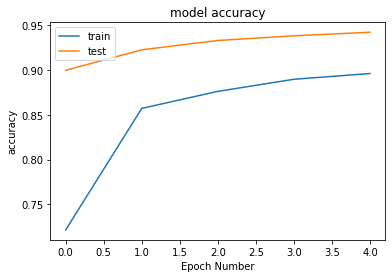

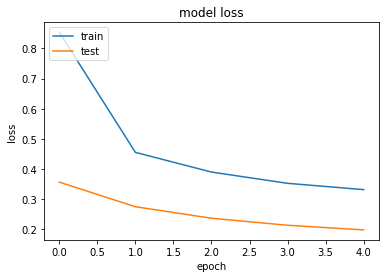

In [25]:
# activation = relu dropout = 0.5
results = model_train(activation_name='softmax',dropout_rate=0.5)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.7503 - accuracy: 0.7676 - val_loss: 0.3568 - val_accuracy: 0.8950
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3802 - accuracy: 0.8830 - val_loss: 0.2767 - val_accuracy: 0.9208
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3059 - accuracy: 0.9054 - val_loss: 0.2293 - val_accuracy: 0.9351
Epoch 4/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2635 - accuracy: 0.9195 - val_loss: 0.2023 - val_accuracy: 0.9410
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.1662 - accuracy: 0.9516


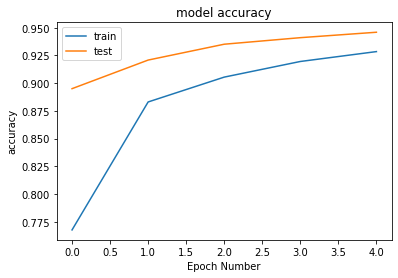

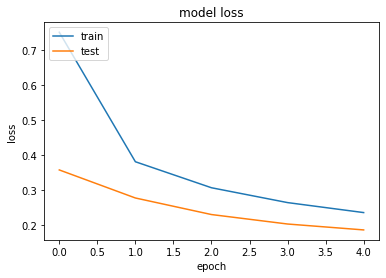

In [26]:
# activation = softmax dropout = 0.2
results = model_train(activation_name='softmax',dropout_rate=0.2)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch Number')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.9011 - accuracy: 0.7050 - val_loss: 0.3474 - val_accuracy: 0.9055
Epoch 2/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.4345 - accuracy: 0.8641 - val_loss: 0.2544 - val_accuracy: 0.9285
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.3601 - accuracy: 0.8865 - val_loss: 0.2154 - val_accuracy: 0.9413
Epoch 4/5
2500/2500 [==============================] - 17s 7ms/step - loss: 0.3233 - accuracy: 0.8972 - val_loss: 0.1941 - val_accuracy: 0.9451
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9539


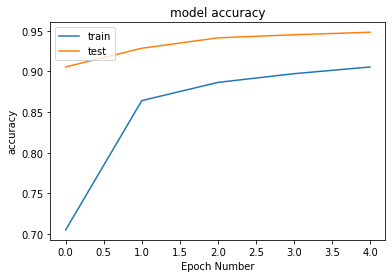

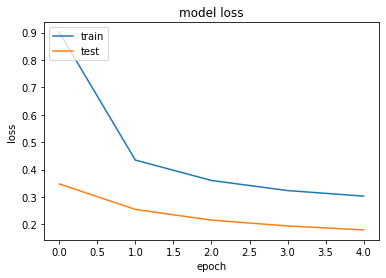

In [27]:
# activation = softmax dropout = 0.5
results = model_train(activation_name='softmax',dropout_rate=0.5)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch Number')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/5
2500/2500 [==============================] - 16s 6ms/step - loss: 1.2510 - accuracy: 0.5736 - val_loss: 0.4381 - val_accuracy: 0.8866
Epoch 2/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.7468 - accuracy: 0.7571 - val_loss: 0.3532 - val_accuracy: 0.9076
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.6963 - accuracy: 0.7708 - val_loss: 0.3373 - val_accuracy: 0.9141
Epoch 4/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.6773 - accuracy: 0.7781 - val_loss: 0.3174 - val_accuracy: 0.9161
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.3002 - accuracy: 0.9291


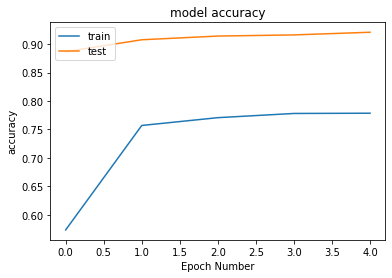

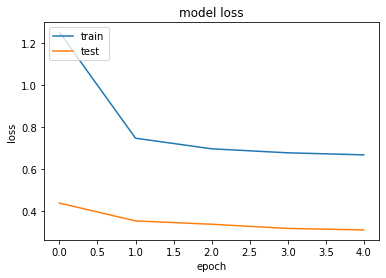

In [28]:
# activation = softmax dropout = 0.8
results = model_train(activation_name='softmax',dropout_rate=0.8)

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch Number')


plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')


plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 다른팀 발표

## 들렸던거 정리
- layer를 늘렸을때 test를 하다가 보면 loss가 확떨어지는 구간이 있었음
- layer 4개인거랑 lyaer 6개인거랑 표현력의 차이가 없었다
- layer를 넓히면 성능이 쪼금 올라가지만 loss도 올라서 불안정해보인다
- layer를 넓히는건 조심해야겠다
- 모델이 복잡해야 learning_rate를 높게잡아도된다
- 실습환경과 같은 환경에선 learning_rate를 0.01 정도로만
- 모델의 깊이 (층)이 깊어질때 
- con-maxpool 
- dropout을 통해 과적합 문제에 집중하여 개선된 모델이라 볼수있다

# 회고

## 배운점
일반적인 Class로 작성하는 모델, 커스텀을 해주는 방식인 SubClass모델, 혼합모델 작성법 및 dropout에 대한

사용자 정의 평가 지표 만드는방법, 사용자정의 콜백 만드는방법

## 아쉬운 점
나의 퀘스트를 제시간안에 못끝내서 다른조가 발표할때 마저 진행하면서 다른조의 발표를 들었는데 좀 자세히 듣고싶었는데 들리는것만 들어서 정리나 지식습득이 좀 아쉬웠다.

그리고 시간이 너무 촉박해서 중복된 코드도 많고, 코드 자체가 더럽다 정리하고싶다


## 느낀 점
서브퀘스트를 수월하게 진행하기엔 아직 실력이 부족하다.

## 어려웠던 점
사용자 정의 평가지표(MAE)는 직접 만들었는데 라이브러리로 구한 MAE와 값의 차이가 크다. 내가 구한건 56정도고 라이브러리로 구한 MAE는 4정도인데 이 차이가 무엇인지 정확히 파악을 시간안에 못했다.